해당 프로젝트 코드는 구글 코랩에서 진행했습니다.
T4 GPU-하드웨어 가속기를 사용하였습니다. (구글 코랩-런타임-런타임 유형 변경-T4 GPU로 사전에 설정합니다.)
또한, face_mask.zip파일은 구글 드라이브 내에 위치하여 /content/drive/Mydrive에 위치해야합니다.

하드웨어 가속기는 다음과 같은 원인으로 진행했습니다.
속도: 하드웨어 가속기는 일반적으로 소프트웨어 방식보다 훨씬 빠르게 작업을 처리할 수 있습니다. 예를 들어, 그래픽 처리 장치(GPU)는 대규모 병렬 처리를 통해 이미지와 비디오 렌더링 작업을 CPU보다 훨씬 빠르게 수행합니다.
병렬 처리: GPU와 같은 하드웨어 가속기는 동시에 여러 작업을 처리할 수 있는 능력을 가지고 있어, 딥러닝과 같은 병렬 처리 작업에서 큰 성능 향상을 제공합니다.
인공지능 및 머신러닝: 딥러닝 모델의 학습과 추론 작업에서 GPU와 TPU(Tensor Processing Unit)는 CPU보다 훨씬 빠른 성능을 제공합니다.

실제로, 하드웨어 가속기를 사용하지 않고 train 데이터를 훈련 시킨 결과 17시간(예상)이 걸렸고, 하드웨어 가속기를 사용시 20분 안으로 훈련이 완료되었습니다.

아래 코드를 활용하여 GPU를 사용하고 있는지 확인할 수 있습니다.

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('GPU device is available: ', tf.test.gpu_device_name())
else:
    print('GPU device is not available.')

GPU device is available:  /device:GPU:0


git clone을 사용하여 yolov5 데이터를 불러오고, 해당 데이터를 이용하여 초기 가중치를 이용할 수 있습니다.
본인은 초기 가중치 yolov5s 모델을 활용하기 위해 git clone을 진행했습니다.

또한, 해당 코드에서는 사용된 라이브러리와 그에 따른 버전을 보여주고 있습니다.

In [ ]:
# YOLOv5 설치
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


아래는 주어진 face_mask.zip 압축 파일을 해제하고 dataset에 파일을 푸는 코드입니다.

In [ ]:
# zipfil 라이브러리 임포트
import zipfile

#압축해제
zip_file='/content/drive/MyDrive/face_mask.zip'
zip_ref=zipfile.ZipFile(zip_file,'r')
zip_ref.extractall('/content/dataset')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/face_mask.zip' mode='r'>>

분류할 데이터를 train, val, test 세 폴더로 나누어 분할합니다(6:2:2 비율)
또한 셔플을 통해 데이터를 분할 했습니다

In [ ]:
import os
import random
import shutil
import yaml
from zipfile import ZipFile
# 경로 설정
data_path = '/content/dataset/face_mask'

# 분할할 디렉토리 생성
train_dir = '/content/trains'
val_dir = '/content/validations'
test_dir = '/content/tests'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 이미지 파일 목록 가져오기
images = [f for f in os.listdir(data_path) if f.endswith('.png')]
random.shuffle(images)

# 데이터 분할 (6:2:2 비율)
train_size = int(len(images) * 0.6)
val_size = int(len(images) * 0.2)

train_images = images[:train_size]
val_images = images[train_size:train_size + val_size]
test_images = images[train_size + val_size:]

# 파일 이동
def move_files(images, src_path, dest_path):
    for image in images:
        shutil.move(os.path.join(src_path, image), dest_path)
        shutil.move(os.path.join(src_path, image.replace('.png', '.txt')), dest_path)

move_files(train_images, data_path, train_dir)
move_files(val_images, data_path, val_dir)
move_files(test_images, data_path, test_dir)

데이터를 6:2:2로 분할되었는지 확인하는 코드입니다. (파일의 수를 세는 함수)
train:801*0.6=480.6,
val: 801*0.2=160.2,
test: 801*0.2=160.2,

위는 분할되어야 하는 데이터 수입니다. 
각각 480개 160개 161개가 나왔는데 정확한 비율로 분할됨을 알 수 있습니다.

In [ ]:
# 데이터셋 경로 설정
train_path = '/content/trains'
val_path = '/content/validations'
test_path = '/content/tests'

# 함수 정의: 폴더 내 이미지 파일 수 세는 함수
def count_images(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    return len(images)

# 각 데이터셋의 이미지 수 확인
num_train_images = count_images(train_path)
num_val_images = count_images(val_path)
num_test_images = count_images(test_path)

print(f"Train 데이터셋: {num_train_images}개 이미지")
print(f"Validation 데이터셋: {num_val_images}개 이미지")
print(f"Test 데이터셋: {num_test_images}개 이미지")

Train 데이터셋: 480개 이미지
Validation 데이터셋: 160개 이미지
Test 데이터셋: 161개 이미지


data.yaml=nc(라벨 명과 라벨 의미 등을 작성하는 추가 코드이며 모델 훈련에서 사용될 예정입니다)

In [ ]:
import yaml

dataset_info = {
    'train': train_path,
    'val': val_path,
    'test': test_path,
    'nc': 3,
    'names': ['good mask', 'no mask', 'incorrect mask']
}

# data.yaml 파일 생성
yaml_file = '/content/data.yaml'

with open(yaml_file, 'w') as f:
    yaml.dump(dataset_info, f, default_flow_style=False)

print(f"data.yaml 파일이 생성되었습니다.")

data.yaml 파일이 생성되었습니다.


하이퍼 파라미터 튜닝은 일반적으로 다른 사람들의 깃허브를 참고하여 초기 모델을 구축하는 데 도움을 받았습니다.

1) 이미지 입력 크기는 640으로 설정했습니다. 초기 418로 진행하였으나 모델의 성능 측면에서 아쉬운 부분이 있어 418로 진행했습니다.
2) 배치 사이즈는 일반적으로 16이라 바꾸지 않았습니다.
3) 에폭 수는 100으로 진행하였습니다. 초기 50으로 진행하였고 손실 함수 및 시각화 그래프를 참고 했을 때 훈련이 덜 된 결과를 보여 에폭 수를 증가시켰습니다.

하이퍼 파라미터 설정에 대한 건입니다

lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0

<학습 관련 하이퍼파라미터>
lr0=0.01: 초기 학습률

학습 초기 단계에서 가중치 업데이트의 크기를 결정합니다. 비교적 높은 초기 학습률을 설정하여 빠른 초기 학습을 유도합니다.
lrf=0.01: 최종 학습률

훈련이 진행될수록 학습률을 낮추어 안정적인 수렴을 도모합니다.
momentum=0.937: 모멘텀

과거의 기울기를 사용하여 현재의 가중치를 업데이트합니다. 큰 모멘텀 값은 학습이 빠르게 수렴하도록 돕습니다.
weight_decay=0.0005: 가중치 감소 (L2 정규화)

모델의 복잡도를 줄여 과적합을 방지합니다. 가중치 크기를 작게 유지합니다.
warmup_epochs=3.0: 웜업 에폭

학습 초기에 학습률을 점진적으로 증가시켜 모델이 안정적으로 학습을 시작할 수 있도록 합니다.
warmup_momentum=0.8: 웜업 모멘텀

초기 웜업 단계에서 모멘텀 값을 설정합니다. 점진적으로 증가시키기 위해 사용됩니다.
warmup_bias_lr=0.1: 웜업 단계에서의 바이어스 학습률

초기 바이어스 학습률을 설정하여 안정적인 시작을 돕습니다.
손실 함수 관련 하이퍼파라미터
box=0.05: 박스 손실 가중치

경계 상자 회귀 손실에 대한 가중치입니다.
cls=0.5: 클래스 손실 가중치

클래스 예측 손실에 대한 가중치입니다.
cls_pw=1.0: 클래스 손실 가중치

클래스 손실에 대한 파워를 설정합니다.
obj=1.0: 객체 손실 가중치

객체 예측 손실에 대한 가중치입니다.
obj_pw=1.0: 객체 손실 가중치

객체 손실에 대한 파워를 설정합니다.
iou_t=0.2: IoU 임계값

예측된 경계 상자가 실제 경계 상자와 얼마나 일치하는지를 나타내는 IoU 임계값입니다. 낮은 값은 더 많은 상자를 포함하도록 합니다.
anchor_t=4.0: 앵커 임계값

앵커의 크기를 조정하여 예측의 정확성을 높입니다.
fl_gamma=0.0: Focal Loss 감마 값


다음과 같은 이유로 학습 관련 파라미터 값을 조정 및 설정하였습니다.

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data /content/data.yaml --weights yolov5s.pt --cache

2024-06-20 13:42:08.621454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 13:42:08.621507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 13:42:08.623154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=Fal

1. 위 훈련결과를 기반으로 그래프 시각화를 하는 코드입니다.
2. 첫째, 에폭별 box loss, objectness loss, classification loss를 한번에 시각화하는 코드입니다.
3. 둘째, 에폭별 Precision, Recall, mAP@0.5, mAP@0.5:0.95를 한번에 시각화하는 코드입니다.

처음 에폭을 50으로 진행했을때와 100으로 진행했을때를 비교하면 loss함수는 큰 변화가 없습니다. 하지만, 에폭을 100으로 진행했을때 성능평가(정확도, 재현율 등)에서
특히 mAP@0.5:0.95가 0.38정도였는데 현재는 0.49로 소량 상승을 보였다고 생각합니다.
mAP@0.5:0.95뿐만아니라, 다른 성능 평가 지표에서도 소량 상승함을 보였습니다.
또한, 이미지 크기를 416에서 640으로 올린 부분에 있어서도 성능이 향상되었기에 위 훈련 코드는 적정하다고 판단합니다.

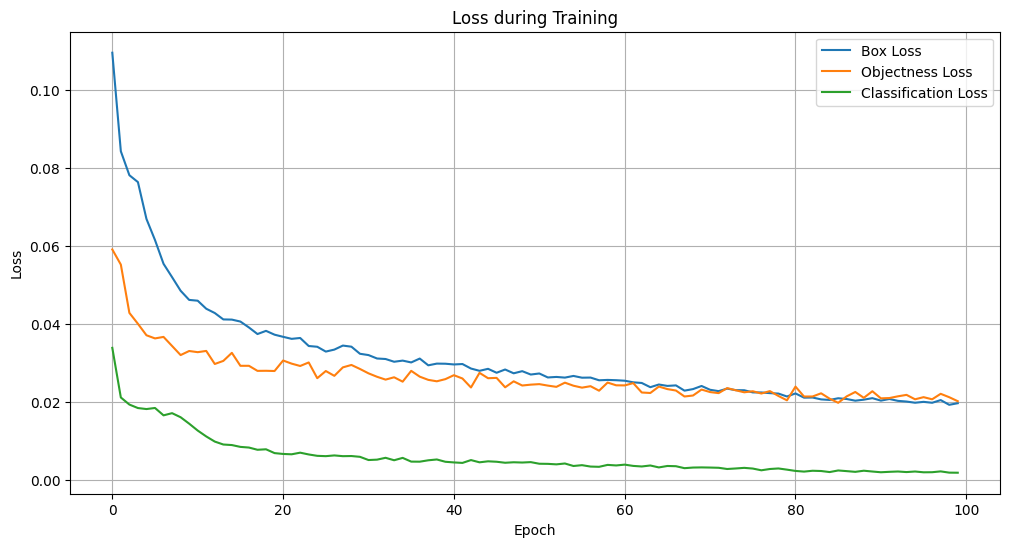

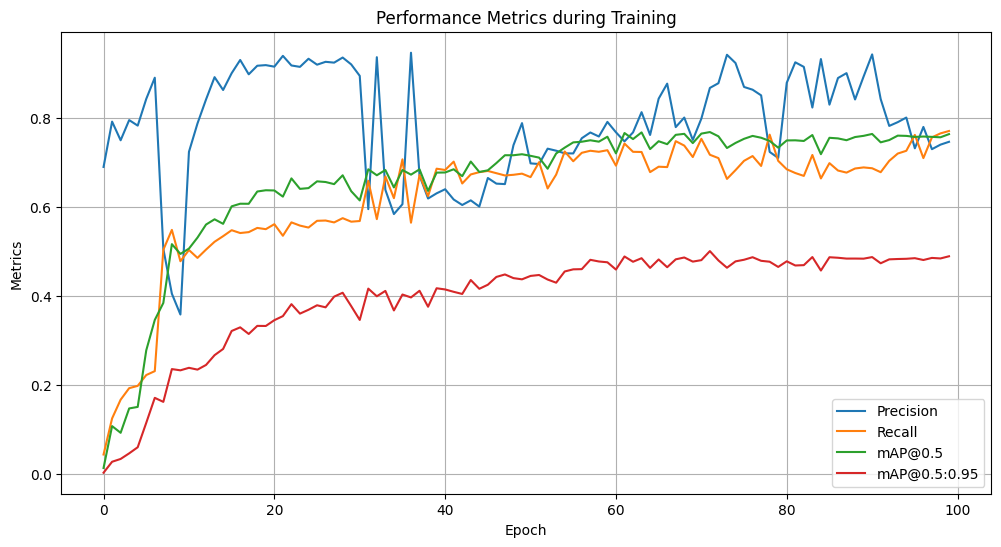

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 경로 설정 (훈련 로그 파일이 저장된 경로)
results_path = '/content/yolov5/runs/train/exp/results.csv'

# 결과 파일 읽기
results = pd.read_csv(results_path)

# 공백 제거
results.columns = results.columns.str.strip()

# 손실 함수 시각화
plt.figure(figsize=(12, 6))
plt.plot(results['epoch'], results['train/box_loss'], label='Box Loss')
plt.plot(results['epoch'], results['train/obj_loss'], label='Objectness Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

# 성능 지표 시각화
plt.figure(figsize=(12, 6))
plt.plot(results['epoch'], results['metrics/precision'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall'], label='Recall')
plt.plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Performance Metrics during Training')
plt.legend()
plt.grid(True)
plt.show()


아래 코드는 마지막 Epoch에 대한 성능 지표입니다.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 경로 설정 (훈련 로그 파일이 저장된 경로)
results_path = '/content/yolov5/runs/train/exp/results.csv'

# 결과 파일 읽기
results = pd.read_csv(results_path)

# 공백 제거
results.columns = results.columns.str.strip()

# 최종 결과 출력
final_results = results.iloc[-1]  # 마지막 에포크의 결과 가져오기

print("Final Results after Training:")
print(f"Epoch: {final_results['epoch']}")
print(f"Box Loss: {final_results['train/box_loss']:.4f}")
print(f"Objectness Loss: {final_results['train/obj_loss']:.4f}")
print(f"Classification Loss: {final_results['train/cls_loss']:.4f}")
print(f"Precision: {final_results['metrics/precision']:.4f}")
print(f"Recall: {final_results['metrics/recall']:.4f}")
print(f"mAP@0.5: {final_results['metrics/mAP_0.5']:.4f}")
print(f"mAP@0.5:0.95: {final_results['metrics/mAP_0.5:0.95']:.4f}")

Final Results after Training:
Epoch: 99.0
Box Loss: 0.0196
Objectness Loss: 0.0202
Classification Loss: 0.0018
Precision: 0.7472
Recall: 0.7715
mAP@0.5: 0.7644
mAP@0.5:0.95: 0.4900


아래는 사진을 시각화하기 위해 필수적인 코드입니다.

In [ ]:
import matplotlib as plt
%matplotlib inline

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


이미지 로드 및 변환 성공
객체 검출 결과: image 1/1: 340x512 11 good masks, 2 no masks
Speed: 2.1ms pre-process, 7.1ms inference, 2.7ms NMS per image at shape (1, 3, 448, 640)


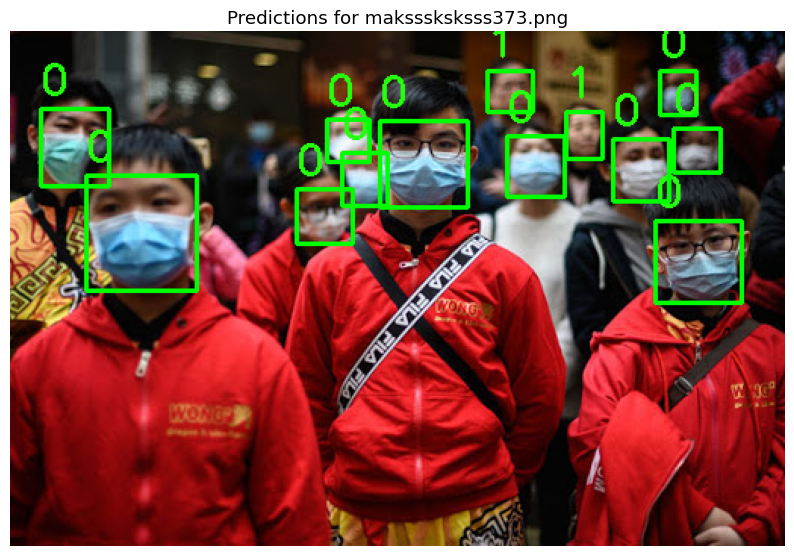

File: maksssksksss373.png, Mask Status: 0, Confidence: 0.94, Box: [50.7443962097168, 95.8805160522461, 123.72127532958984, 171.0356903076172]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.94, Box: [328.47686767578125, 69.26776123046875, 366.8562927246094, 109.92529296875]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.92, Box: [244.1213836669922, 59.88236618041992, 302.8195495605469, 116.19231414794922]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.92, Box: [426.7522888183594, 125.48320770263672, 483.5956726074219, 179.8086700439453]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.92, Box: [189.89292907714844, 104.6471176147461, 226.2495574951172, 140.2152862548828]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.92, Box: [398.4811706542969, 71.4478530883789, 435.66265869140625, 112.63912200927734]
File: maksssksksss373.png, Mask Status: 0, Confidence: 0.91, Box: [20.101654052734375, 51.051605224609375, 65.31265258789062, 102.1953964233

In [38]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random

# 사용자 훈련 모델 경로
custom_model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# 사용자 훈련 모델 불러오기
model = torch.hub.load('ultralytics/yolov5', 'custom', path=custom_model_path)

# 이미지 파일이 저장된 디렉토리 경로
directory_path = '/content/tests'

# 디렉토리 내 .png 파일 목록 가져오기
image_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]

# .png 파일이 존재하는지 확인
if not image_files:
    print(f"{directory_path} 디렉토리에 .png 파일이 없습니다.")
else:
    # 무작위로 파일 선택
    selected_file = random.choice(image_files)
    image_path = os.path.join(directory_path, selected_file)

    # 이미지 로드
    img = cv2.imread(image_path)

    # 이미지가 제대로 로드되었는지 확인
    if img is None:
        print(f"이미지를 로드할 수 없습니다: {image_path}")
    else:
        # OpenCV에서 BGR 형식을 RGB로 변환
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 이미지 로드 및 변환 확인
        print("이미지 로드 및 변환 성공")

        # YOLOv5를 사용하여 객체 검출
        results = model(img_rgb)

        # 검출 결과 확인
        print("객체 검출 결과:", results)

        # 검출 결과에서 바운딩 박스와 클래스 추출
        detections = results.xyxy[0]  # 첫 번째 이미지에 대한 검출 결과를 가져옴
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현

            # 바운딩 박스 그리기
            cv2.rectangle(img_rgb, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            # 라벨과 마스크 상태 표시
            cv2.putText(img_rgb, f'{mask_status}', (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

  #(0:마스크 잘 착용, 1: 미착용 2: 부적절하게 착용)

        # 결과 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predictions for {image_path.split('/')[-1]}")
        plt.show()

        # 예측된 라벨 및 바운딩 박스 정보 출력
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현
            print(f"File: {image_path.split('/')[-1]}, Mask Status: {mask_status}, Confidence: {conf:.2f}, Box: [{xmin}, {ymin}, {xmax}, {ymax}]")


위 코드 시각화 결과와 달리 아래 코드 시각화에서는 숫자와 라벨 문구까지 추가했습니다

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


이미지 로드 및 변환 성공
객체 검출 결과: image 1/1: 225x400 1 good mask, 7 no masks
Speed: 1.8ms pre-process, 8.6ms inference, 3.1ms NMS per image at shape (1, 3, 384, 640)


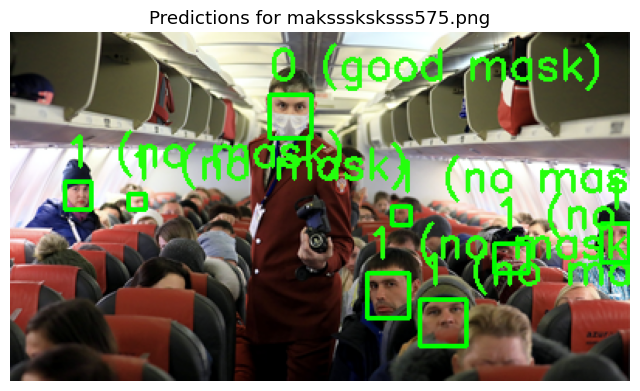

File: maksssksksss575.png, Mask Status: 0 (good mask), Confidence: 0.92, Box: [167.23085021972656, 40.7425651550293, 194.20266723632812, 68.67318725585938]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.90, Box: [264.7204284667969, 172.25018310546875, 294.2075500488281, 202.8321075439453]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.90, Box: [230.5341796875, 155.82456970214844, 257.0761413574219, 184.78746032714844]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.83, Box: [35.85108184814453, 96.94385528564453, 52.93763732910156, 114.42831420898438]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.81, Box: [381.37188720703125, 123.64604949951172, 399.5281677246094, 148.337646484375]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.74, Box: [312.1485595703125, 136.3628387451172, 334.7890625, 155.78753662109375]
File: maksssksksss575.png, Mask Status: 1 (no mask), Confidence: 0.66, Box: [246.6

In [42]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random

# 사용자 훈련 모델 경로
custom_model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# 사용자 훈련 모델 불러오기
model = torch.hub.load('ultralytics/yolov5', 'custom', path=custom_model_path)

# 이미지 파일이 저장된 디렉토리 경로
directory_path = '/content/tests'

# 디렉토리 내 .png 파일 목록 가져오기
image_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]

# .png 파일이 존재하는지 확인
if not image_files:
    print(f"{directory_path} 디렉토리에 .png 파일이 없습니다.")
else:
    # 무작위로 파일 선택
    selected_file = random.choice(image_files)
    image_path = os.path.join(directory_path, selected_file)

    # 이미지 로드
    img = cv2.imread(image_path)

    # 이미지가 제대로 로드되었는지 확인
    if img is None:
        print(f"이미지를 로드할 수 없습니다: {image_path}")
    else:
        # OpenCV에서 BGR 형식을 RGB로 변환
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 이미지 로드 및 변환 확인
        print("이미지 로드 및 변환 성공")

        # YOLOv5를 사용하여 객체 검출
        results = model(img_rgb)

        # 검출 결과 확인
        print("객체 검출 결과:", results)

        # 클래스 이름 매핑
        class_names = {0: 'good mask', 1: 'no mask', 2: 'incorrect mask'}

        # 검출 결과에서 바운딩 박스와 클래스 추출
        detections = results.xyxy[0]  # 첫 번째 이미지에 대한 검출 결과를 가져옴
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현
            mask_label = class_names.get(mask_status, 'Unknown')  # 숫자를 텍스트 라벨로 변환

            # 바운딩 박스 그리기
            cv2.rectangle(img_rgb, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            # 라벨과 마스크 상태 표시 (숫자와 텍스트 라벨)
            cv2.putText(img_rgb, f'{mask_status} ({mask_label})', (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        # 결과 시각화
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predictions for {image_path.split('/')[-1]}")
        plt.show()

        # 예측된 라벨 및 바운딩 박스 정보 출력
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현
            mask_label = class_names.get(mask_status, 'Unknown')  # 숫자를 텍스트 라벨로 변환
            print(f"File: {image_path.split('/')[-1]}, Mask Status: {mask_status} ({mask_label}), Confidence: {conf:.2f}, Box: [{xmin}, {ymin}, {xmax}, {ymax}]")


아래 코드는 오류 사진을 보여주기 위한 코드입니다.
여러 번의 실행을 했지만, 오류가 발생한 사진을 찾기 힘들었습니다.
우측 노랑 색 옷을 입은 중년의 남성을 보면 마스크를 착용하지 않았기에 1이 나와야 하는데
2가 나온 결과를 확인할 수 있습니다.
따라서 해당 부분은 예측 결과의 오류라고 볼 수 있습니다.

예측 오류를 해결하기위해서는 하이퍼 파라미터를 튜닝을 할 수 있습니다.
또한, 현재 손실함수와 성능 지표의 시각화 그래프를 살펴보면 에폭이 약 85정도에서 가장 좋은 성능을 보이고 있는것같습니다.
따라서, 과적합 방지를 위해 에폭을 85로 조정하면 더 좋은 예측 모델이 될 것같습니다.

하지만, 현재 코드에서는 오류를 시각화하고 싶어 에폭을 99(100)으로 설정하였습니다.

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


이미지 로드 및 변환 성공
객체 검출 결과: image 1/1: 225x400 9 good masks, 8 no masks, 2 incorrect masks
Speed: 2.1ms pre-process, 9.6ms inference, 1.8ms NMS per image at shape (1, 3, 384, 640)


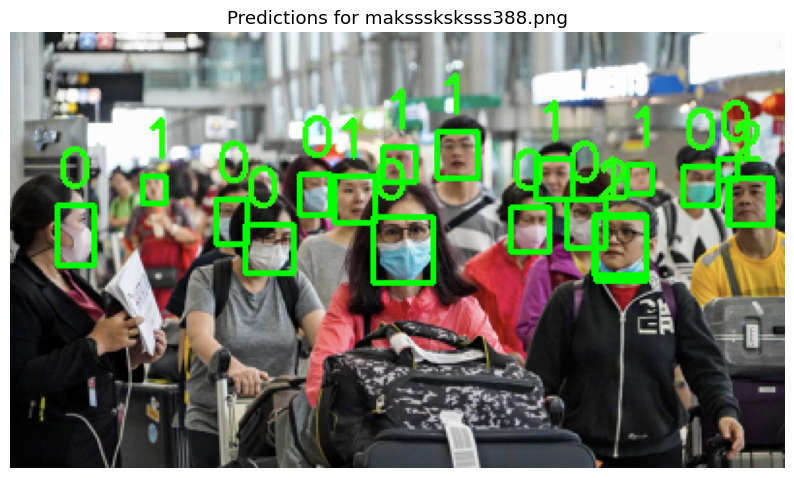

File: maksssksksss388.png, Mask Status: 0, Confidence: 0.92, Box: [24.33978843688965, 89.14102172851562, 43.25844192504883, 120.8780288696289]
File: maksssksksss388.png, Mask Status: 0, Confidence: 0.91, Box: [187.98683166503906, 95.07865142822266, 218.72467041015625, 129.14968872070312]
File: maksssksksss388.png, Mask Status: 0, Confidence: 0.90, Box: [121.10884094238281, 99.87492370605469, 146.08425903320312, 124.61272430419922]
File: maksssksksss388.png, Mask Status: 1, Confidence: 0.90, Box: [167.57357788085938, 74.31990051269531, 188.24996948242188, 98.93019104003906]
File: maksssksksss388.png, Mask Status: 0, Confidence: 0.90, Box: [287.7608337402344, 86.90721130371094, 307.649169921875, 111.34151458740234]
File: maksssksksss388.png, Mask Status: 1, Confidence: 0.89, Box: [220.67916870117188, 51.508907318115234, 241.56619262695312, 75.27946472167969]
File: maksssksksss388.png, Mask Status: 0, Confidence: 0.89, Box: [347.5186462402344, 69.4638442993164, 365.0088195800781, 89.00839

In [86]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random

# 사용자 훈련 모델 경로
custom_model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# 사용자 훈련 모델 불러오기
model = torch.hub.load('ultralytics/yolov5', 'custom', path=custom_model_path)

# 이미지 파일이 저장된 디렉토리 경로
directory_path = '/content/tests'

# 디렉토리 내 .png 파일 목록 가져오기
image_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]

# .png 파일이 존재하는지 확인
if not image_files:
    print(f"{directory_path} 디렉토리에 .png 파일이 없습니다.")
else:
    # 무작위로 파일 선택
    selected_file = random.choice(image_files)
    image_path = os.path.join(directory_path, selected_file)

    # 이미지 로드
    img = cv2.imread(image_path)

    # 이미지가 제대로 로드되었는지 확인
    if img is None:
        print(f"이미지를 로드할 수 없습니다: {image_path}")
    else:
        # OpenCV에서 BGR 형식을 RGB로 변환
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 이미지 로드 및 변환 확인
        print("이미지 로드 및 변환 성공")

        # YOLOv5를 사용하여 객체 검출
        results = model(img_rgb)

        # 검출 결과 확인
        print("객체 검출 결과:", results)

        # 검출 결과에서 바운딩 박스와 클래스 추출
        detections = results.xyxy[0]  # 첫 번째 이미지에 대한 검출 결과를 가져옴
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현

            # 바운딩 박스 그리기
            cv2.rectangle(img_rgb, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            # 라벨과 마스크 상태 표시
            cv2.putText(img_rgb, f'{mask_status}', (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

  #(0:마스크 잘 착용, 1: 미착용 2: 부적절하게 착용)

        # 결과 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predictions for {image_path.split('/')[-1]}")
        plt.show()

        # 예측된 라벨 및 바운딩 박스 정보 출력
        for detection in detections:
            xmin, ymin, xmax, ymax, conf, cls = detection
            mask_status = int(cls)  # 마스크 상태를 숫자로만 표현
            print(f"File: {image_path.split('/')[-1]}, Mask Status: {mask_status}, Confidence: {conf:.2f}, Box: [{xmin}, {ymin}, {xmax}, {ymax}]")


현재까지의 코드에서는 테스트 데이터셋에 대한 예측 결과를 시각화하고, 각 예측에 대한 신뢰도와 바운딩 박스 정보를 출력하지만, 전체 테스트 데이터셋에 대한 정확도를 계산하는 부분은 없습니다. 
이를 위해 다음과 같은 코드를 추가할 수 있습니다:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 테스트 데이터셋에 대한 예측 결과 수집
true_labels = []
predicted_labels = []

for image_file in image_files:
    image_path = os.path.join(directory_path, image_file)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_rgb)
    detections = results.xyxy[0]
    
    # 실제 라벨과 예측 라벨 추출 (예: 파일명에서 라벨 정보를 추출하는 방식)
    true_label = int(image_file.split('_')[0])  # 예시: 파일명에서 라벨 추출
    true_labels.append(true_label)
    
    if len(detections) > 0:
        predicted_label = int(detections[0][5])  # 첫 번째 검출 결과의 클래스
        predicted_labels.append(predicted_label)
    else:
        predicted_labels.append(-1)  # 검출되지 않은 경우

# 정확도 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# 분류 리포트 출력
print(classification_report(true_labels, predicted_labels, target_names=['good mask', 'no mask', 'incorrect mask']))

[결론 및 느낀점]

이 프로젝트는 YOLOv5를 활용하여 마스크 착용 여부를 자동으로 분석하는 시스템을 구축하는 과정을 다루었습니다. 이를 통해 딥러닝 기반 객체 검출 기술의 강력함과 실용성을 체감할 수 있었습니다. 특히, YOLOv5는 실시간 객체 검출에 적합하며, 비교적 적은 데이터로도 높은 정확도를 달성할 수 있다는 점이 인상적이었습니다.

[느낀 점]
데이터의 중요성:
모델의 성능은 데이터의 품질과 양에 크게 의존한다는 것을 다시 한번 깨달았습니다. 데이터셋이 충분히 다양하고 균형 잡혀 있지 않으면 모델의 일반화 성능이 떨어질 수 있습니다. 따라서 데이터 수집 및 전처리 단계에서 더 많은 시간과 노력을 투자해야 할 필요성을 느꼈습니다.

하이퍼파라미터 튜닝의 필요성:
학습률, 배치 크기, 에포크 수 등의 하이퍼파라미터를 적절히 조정하지 않으면 모델의 성능이 최적화되지 않을 수 있습니다. 이를 위해 그리드 서치(grid search)나 베이지안 최적화(Bayesian optimization)와 같은 기법을 적용해 보는 것도 좋은 방법이라고 생각합니다.

모델 평가의 중요성:
모델의 성능을 정량적으로 평가하기 위해 정확도, 정밀도, 재현율, F1 점수 등의 지표를 사용하는 것이 중요합니다. 특히, 불균형 데이터셋의 경우 정확도만으로는 모델의 성능을 제대로 평가할 수 없으므로, 다양한 평가 지표를 함께 고려해야 합니다.

실시간 적용 가능성:
YOLOv5는 실시간 객체 검출에 매우 적합한 모델입니다. 이를 활용하면 실시간 영상 분석 시스템(예: CCTV, 스마트 도어 등)에 쉽게 적용할 수 있을 것으로 기대됩니다. 다만, 실제 환경에서는 조명 조건, 카메라 각도, 배경 복잡도 등 다양한 변수가 존재하므로, 이러한 요소들을 고려한 추가적인 테스트가 필요할 것입니다.



[추가 개선 사항]
데이터 증강(Data Augmentation):
데이터셋의 크기와 다양성을 높이기 위해 회전, 확대/축소, 색상 조정, 노이즈 추가 등의 데이터 증강 기법을 적용할 수 있습니다. 이는 모델의 일반화 성능을 향상시키는 데 도움이 될 것입니다.

교차 검증(Cross-Validation):
K-폴드 교차 검증을 사용하여 모델의 성능을 더 정확하게 평가할 수 있습니다. 이를 통해 데이터셋의 분할에 따른 편향을 줄일 수 있습니다.

추가 평가 지표:
현재 코드에서는 테스트 데이터셋에 대한 정확도만 계산하고 있습니다. 추가적으로 정밀도(Precision), 재현율(Recall), F1 점수(F1-Score) 등을 계산하여 모델의 성능을 더욱 세밀하게 평가할 수 있습니다.

실시간 영상 분석:
웹캠이나 동영상을 입력으로 받아 실시간으로 마스크 착용 여부를 분석하는 기능을 추가할 수 있습니다. 이를 통해 모델의 실용성을 더욱 높일 수 있습니다.

최종 정리
이 프로젝트는 YOLOv5를 사용하여 마스크 착용 여부를 분석하는 시스템을 구축하는 데 초점을 맞췄습니다. 데이터 전처리, 모델 학습, 평가, 시각화 등 전반적인 과정을 경험하며 딥러닝 모델의 동작 원리와 적용 방법을 깊이 이해할 수 있었습니다. 특히, 객체 검출 모델의 강점과 한계를 직접 체험하며, 이를 실제 문제에 적용하는 데 필요한 고려사항들을 배울 수 있었습니다.

추가적으로, 데이터 증강, 하이퍼파라미터 튜닝, 교차 검증, 실시간 분석 기능 등을 통해 모델의 성능을 더욱 향상시킬 수 있을 것으로 기대됩니다. 이러한 개선 사항들을 적용한다면, 더욱 정확하고 안정적인 마스크 착용 분석 시스템을 구축할 수 있을 것입니다.

In [ ]:
# 추가 코드 예시: 실시간 영상 분석

import cv2
import torch

# 사용자 훈련 모델 경로
custom_model_path = '/content/yolov5/runs/train/exp/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=custom_model_path)

# 웹캠 열기
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # YOLOv5를 사용하여 객체 검출
    results = model(frame)

    # 검출 결과 시각화
    results.render()  # 바운딩 박스와 라벨을 이미지에 추가
    cv2.imshow('Mask Detection', results.ims[0])

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()